In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import random

In [2]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1

    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]

    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):

    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')

    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [5]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images / 255.0
test_images = test_images / 255.0

tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

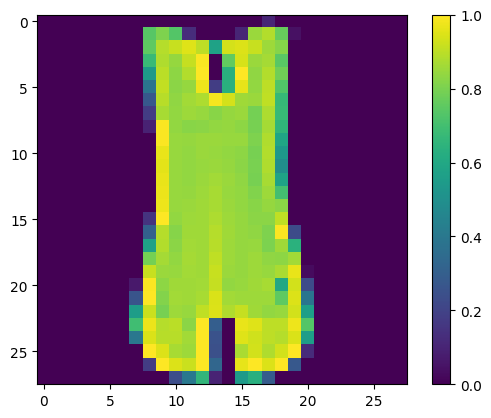

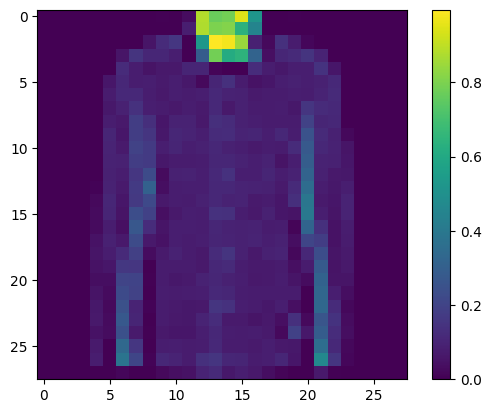

0.0


In [9]:
this_pair = 5
show_image(tr_pairs[this_pair][0])
show_image(tr_pairs[this_pair][1])
print(tr_y[this_pair])

In [12]:
def initialize_base_network():
  input = tf.keras.layers.Input(shape=(28, 28), name="base_input")
  x = tf.keras.layers.Flatten(name="flatten_input")(input)
  x = tf.keras.layers.Dense(128, activation="relu", name="first_dense_layer")(x)
  x = tf.keras.layers.Dropout(0.1, name="first_dropout_layer")(x)
  x = tf.keras.layers.Dense(128, activation="relu", name="second_dense_layer")(x)
  x = tf.keras.layers.Dropout(0.1, name="second_dropout_layer")(x)
  x = tf.keras.layers.Dense(128, activation="relu", name="third_dense_layer")(x)
  return tf.keras.Model(inputs=input, outputs=x)

def euclidean_distance(vects):
  x, y = vects
  sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

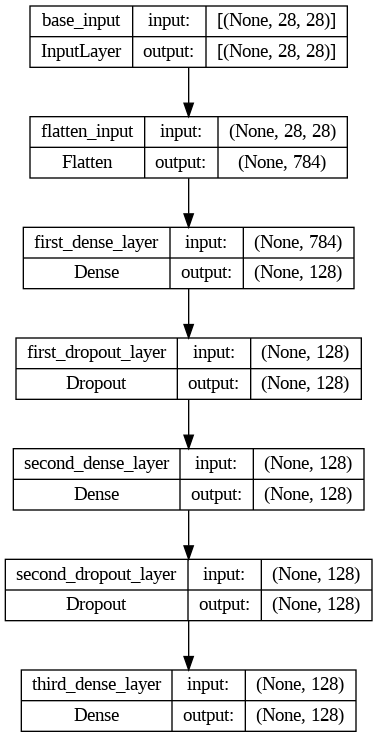

In [16]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True)

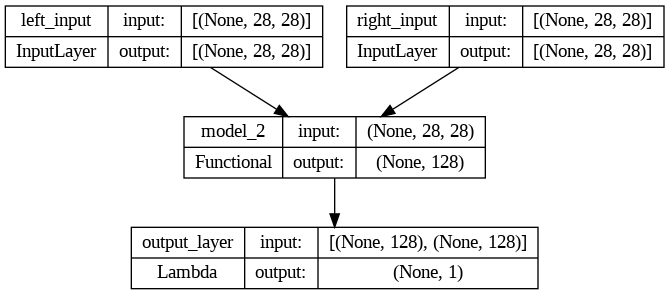

In [18]:
input_a = tf.keras.layers.Input(shape=(28, 28), name="left_input")
vect_output_a = base_network(input_a)
input_b = tf.keras.layers.Input(shape=(28, 28), name="right_input")
vect_output_b = base_network(input_b)

output = tf.keras.layers.Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])
model = tf.keras.Model([input_a, input_b], output)

plot_model(model, show_shapes=True)

In [19]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [21]:
model.compile(loss=contrastive_loss_with_margin(margin=1),
              optimizer=tf.keras.optimizers.RMSprop())
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]],
                    tr_y,
                    epochs=20,
                    batch_size=128,
                    validation_data=([ts_pairs[:,0], ts_pairs[:, 1]], ts_y))

Epoch 1/20
938/938 [==============================] - 14s 14ms/step - loss: 0.1120 - val_loss: 0.0877
Epoch 2/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0822 - val_loss: 0.0767
Epoch 3/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0740 - val_loss: 0.0719
Epoch 4/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0690 - val_loss: 0.0679
Epoch 5/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0653 - val_loss: 0.0673
Epoch 6/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0627 - val_loss: 0.0661
Epoch 7/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0605 - val_loss: 0.0659
Epoch 8/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0591 - val_loss: 0.0657
Epoch 9/20
938/938 [==============================] - 10s 10ms/step - loss: 0.0580 - val_loss: 0.0633
Epoch 10/20
938/938 [==============================] - 12s 12ms/step - loss: 0.0569 - val_

In [23]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [24]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step
Loss = 0.0624820739030838, Train Accuracy = 0.9397232872145358 Test Accuracy = 0.9151651651651652


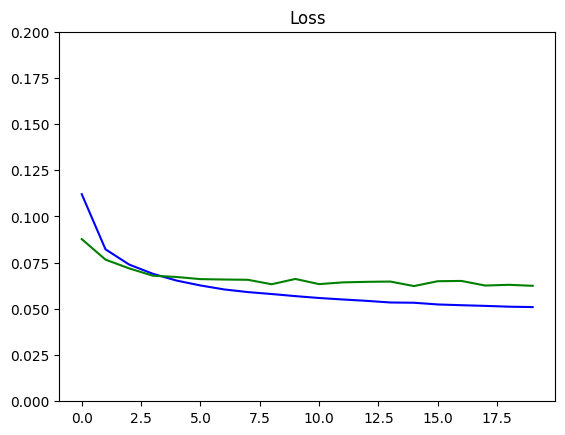

In [25]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [27]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

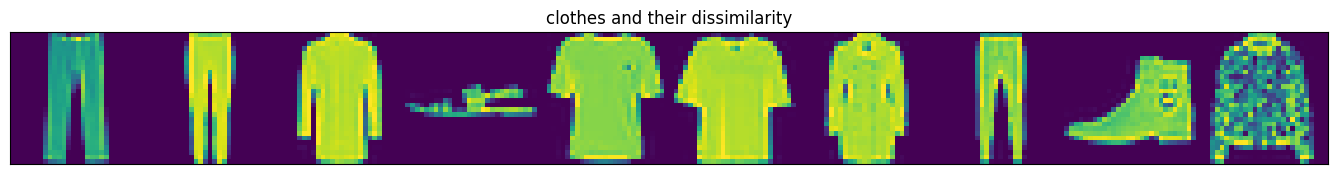

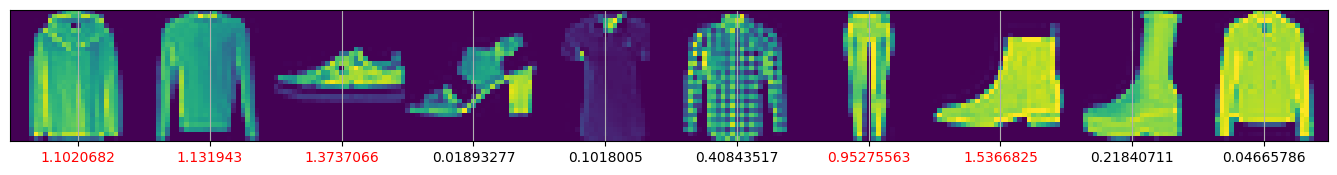

In [30]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)